In [31]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

print "series: " + str(series.shape)
print series[0:3]

# transform data to be stationary
raw_values = series.values
print "raw_values: " + str(raw_values.shape)
print raw_values[0:3,]
diff_values = difference(raw_values, 1)
print "diff_values: " + str(diff_values.shape)
print diff_values[0:3]

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
print "supervised: " + str(supervised.shape)
print supervised[0:5]
supervised_values = supervised.values
print "supervised_values: " + str(supervised_values.shape)
print supervised_values[0:5]

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
print "train: " + str(train.shape)
print train[0:5]
print "test: " + str(test.shape)
print test[0:5]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# print "scaler: " + str(scaler.shape)
print "train_scaled: " + str(train_scaled.shape)
print train_scaled[0:5]
print "test_scaled: " + str(test_scaled.shape)
print test_scaled[0:5]

# fit the model
# lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# # forecast the entire training dataset to build up state for forecasting
# train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
# lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
# predictions = list()
# for i in range(len(test_scaled)):
# 	# make one-step forecast
# 	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
# 	yhat = forecast_lstm(lstm_model, 1, X)
# 	# invert scaling
# 	yhat = invert_scale(scaler, X, yhat)
# 	# invert differencing
# 	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
# 	# store forecast
# 	predictions.append(yhat)
# 	expected = raw_values[len(train) + i + 1]
# 	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# # report performance
# rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
# print('Test RMSE: %.3f' % rmse)
# # line plot of observed vs predicted
# pyplot.plot(raw_values[-12:])
# pyplot.plot(predictions)
# pyplot.show()

series: (36,)
Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
Name: Sales of shampoo over a three year period, dtype: float64
raw_values: (36,)
[ 266.   145.9  183.1]
diff_values: (35,)
0   -120.1
1     37.2
2    -63.8
dtype: float64
supervised: (35, 2)
       0      0
0    0.0 -120.1
1 -120.1   37.2
2   37.2  -63.8
3  -63.8   61.0
4   61.0  -11.8
supervised_values: (35, 2)
[[   0.  -120.1]
 [-120.1   37.2]
 [  37.2  -63.8]
 [ -63.8   61. ]
 [  61.   -11.8]]
train: (23, 2)
[[   0.  -120.1]
 [-120.1   37.2]
 [  37.2  -63.8]
 [ -63.8   61. ]
 [  61.   -11.8]]
test: (12, 2)
[[  77.8   -2.6]
 [  -2.6  100.7]
 [ 100.7 -124.5]
 [-124.5  123.4]
 [ 123.4  -38. ]]
train_scaled: (23, 2)
[[-0.15241435 -0.80037766]
 [-0.80037766  0.04828702]
 [ 0.04828702 -0.496628  ]
 [-0.496628    0.17669274]
 [ 0.17669274 -0.21607769]]
test_scaled: (12, 2)
[[ 0.26733207 -0.16644187]
 [-0.16644187  0.39088211]
 [ 0.39088211 -0.82411654]
 [-0.82411654  0.51335312]
 [ 0.51335312 -0.35743189]]


In [33]:
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy
print('numpy: {}'.format(numpy.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas
print('pandas: {}'.format(pandas.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))

scipy: 0.18.1
numpy: 1.13.3
matplotlib: 2.0.0
pandas: 0.19.2
sklearn: 0.18.1


In [7]:
import requests
import datetime
import json

def get_curr_urls():
    btc_url = 'https://min-api.cryptocompare.com/data/histohour?fsym=BTC&tsym=USD&toTs={TO_TS}&tryConversion=false&limit=2000'
    eth_url = 'https://min-api.cryptocompare.com/data/histohour?fsym=ETH&tsym=BTC&toTs={TO_TS}&tryConversion=false&limit=2000'
    ltc_url = 'https://min-api.cryptocompare.com/data/histohour?fsym=LTC&tsym=BTC&toTs={TO_TS}&tryConversion=false&limit=2000'
    xrp_url = 'https://min-api.cryptocompare.com/data/histohour?fsym=XRP&tsym=BTC&toTs={TO_TS}&tryConversion=false&limit=2000'
    dash_url = 'https://min-api.cryptocompare.com/data/histohour?fsym=DASH&tsym=BTC&toTs={TO_TS}&tryConversion=false&limit=2000'

    curr_urls = {}
    curr_urls['btc'] = btc_url
    curr_urls['eth'] = eth_url
    curr_urls['ltc'] = ltc_url
    curr_urls['xrp'] = xrp_url
    curr_urls['dash'] = dash_url

    return curr_urls

def get_btc_json(to_timestamp):
    btc_url = 'https://min-api.cryptocompare.com/data/histohour?fsym=BTC&tsym=USD&toTs='+str(toTS)+'&tryConversion=false&limit=2000'
    btc_response = requests.post(btc_url)
    btc_json = btc_response.json()
    save_json('./data/raw_responses/btc-response-'+str(toTs)+'.json', btc_json)
    return btc_json

def get_response_filename(curr_symbol, to_timestamp):
    return './data/raw_responses/new-'+curr_symbol+'-response-'+str(to_timestamp)+'.json'

def get_currency_url(curr_symbol, to_timestamp):
    curr_urls = get_curr_urls()
    if curr_symbol not in curr_urls:
        print curr_symbol + ' URL is not present in ' + str(curr_urls)
        return
    url = curr_urls[curr_symbol]
    url = url.replace('{TO_TS}', str(to_timestamp))
    return url

def get_curr_json(curr_symbol, to_timestamp):
    url = get_currency_url(curr_symbol, to_timestamp)
    response = requests.post(url)
    json = response.json()
    save_json(get_response_filename(curr_symbol, to_timestamp), json)
    return json


In [18]:

# convert timestamp to formated string date
def parse_ts(timestamp):
    return datetime.datetime.fromtimestamp(
        int(timestamp)
    ).strftime('%Y-%m-%d %H:%M:%S')

# convert currency price in BTC at ts to dollar, given BTC prices
def convert_to_dollar(price, ts, btc_prices):
    if ts not in btc_prices:
        print 'BTC not available for: ' + parse_ts(ts)
        return;
    return price * btc_prices[ts]

def add_prices(curr_symbol, source_dict, target_dict, btc_dict, btc_prices):
    for value in source_dict:
        if value['time'] not in target_dict:
            print 'Adding time ' + parse_ts(value['time']) + ' for ' + curr_symbol
            target_dict[value['time']] = {}
            btc_dict[value['time']] = {}
        target_dict[value['time']][curr_symbol] = convert_to_dollar(value['close'], value['time'], btc_prices)
        btc_dict[value['time']][curr_symbol] = value['close']
        
def save_json(filename, response):
    with open(filename, 'w') as fp:
        json.dump(response, fp)

def get_prices(btc_prices, btc_dict, dollar_dict, to_timestamp):
    btc_json = get_curr_json('btc', to_timestamp)
    for value in btc_json['Data']:
        if value['time'] not in dollar_dict:
            btc_dict[value['time']] = {}
            dollar_dict[value['time']] = {}
        else:
            print 'Duplicate value at ' + parse_ts(value['time'])        
        dollar_dict[value['time']]['btc'] = value['close']
        btc_dict[value['time']]['btc'] = value['close']
        btc_prices[value['time']] = value['close']
    
    eth_json = get_curr_json('eth', to_timestamp)
    add_prices('eth', eth_json['Data'], dollar_dict, btc_dict, btc_prices)
    ltc_json = get_curr_json('ltc', to_timestamp)
    add_prices('ltc', ltc_json['Data'], dollar_dict, btc_dict, btc_prices)
    xrp_json = get_curr_json('xrp', to_timestamp)
    add_prices('xrp', xrp_json['Data'], dollar_dict, btc_dict, btc_prices)
    dash_json = get_curr_json('dash', to_timestamp)
    add_prices('dash', dash_json['Data'], dollar_dict, btc_dict, btc_prices)
    
dollar_dict = {}
btc_prices = {}
btc_dict = {}

to_timestamp = 1451606400 # 1/1/2016 00:00:00

import time

now = time.time()

while to_timestamp < now:
    print 'Loading data for ' + parse_ts(to_timestamp)
    get_prices(btc_prices, btc_dict, dollar_dict, to_timestamp)
    save_json('./data/prices/dollar-prices-'+str(to_timestamp)+'.json', dollar_dict)
    save_json('./data/prices/btc-prices-'+str(to_timestamp)+'.json', btc_dict)
    to_timestamp = to_timestamp + (1990 * 60 * 60)
    time.sleep(3)
    
print dollar_dict.values()[0]
print btc_dict.values()[0]

Duplicate value at 2015-12-31 15:00:00
Duplicate value at 2015-12-31 16:00:00
Duplicate value at 2015-12-31 17:00:00
Duplicate value at 2015-12-31 18:00:00
Duplicate value at 2015-12-31 19:00:00
Duplicate value at 2015-12-31 20:00:00
Duplicate value at 2015-12-31 21:00:00
Duplicate value at 2015-12-31 22:00:00
Duplicate value at 2015-12-31 23:00:00
Duplicate value at 2016-01-01 00:00:00
Duplicate value at 2016-01-01 01:00:00
Duplicate value at 2016-03-23 13:00:00
Duplicate value at 2016-03-23 14:00:00
Duplicate value at 2016-03-23 15:00:00
Duplicate value at 2016-03-23 16:00:00
Duplicate value at 2016-03-23 17:00:00
Duplicate value at 2016-03-23 18:00:00
Duplicate value at 2016-03-23 19:00:00
Duplicate value at 2016-03-23 20:00:00
Duplicate value at 2016-03-23 21:00:00
Duplicate value at 2016-03-23 22:00:00
Duplicate value at 2016-03-23 23:00:00
Duplicate value at 2016-06-14 12:00:00
Duplicate value at 2016-06-14 13:00:00
Duplicate value at 2016-06-14 14:00:00
Duplicate value at 2016-0

In [46]:
for ts in dollar_dict.keys():
    if len(dollar_dict[ts]) != 5:
        print '.'
    if dollar_dict[ts] == 'NaN':
        print '-'
print len(dollar_dict)

import csv
with open('all_btc_prices.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['date', 'btc', 'eth', 'ltc', 'xrp', 'dash'])
    
    keys = btc_dict.keys()
    keys.sort()
    
    for key in keys:
#         spamwriter.writerow([parse_ts(key), dollar_dict[key]['btc'], dollar_dict[key]['eth'], dollar_dict[key]['ltc'], dollar_dict[key]['xrp'], dollar_dict[key]['dash']])
        spamwriter.writerow([parse_ts(key), btc_dict[key]['btc'], btc_dict[key]['eth'], btc_dict[key]['ltc'], btc_dict[key]['xrp'], btc_dict[key]['dash']])
    
    

17921


                    btc               eth               ltc               xrp              dash
count  17921.0000000000  17921.0000000000  17921.0000000000  17921.0000000000  17921.0000000000
mean    1269.6129842085     69.9675337267     13.8441134695      0.0579280423     63.5096692032
std     1276.4064648651    111.3312389405     18.6452279527      0.0934392051     98.1114083562
min      243.0900000000      0.4230123600      2.7796309200      0.0039910390      2.0146021600
25%      444.4700000000      8.3456033200      3.6095058000      0.0060977840      6.5651418000
50%      677.4000000000     11.6875458000      3.9050967200      0.0068500068     10.3931406000
75%     1261.0900000000     50.3702640000     12.2936515200      0.0346512600     86.6029545000
max     6146.3200000000    399.8438850000     90.5218250000      0.4049072280    406.2847899000
               btc           eth           ltc           xrp          dash
btc   1.0000000000  0.9413655104  0.9524333662  0.8474271499 

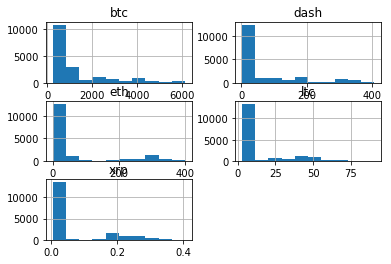

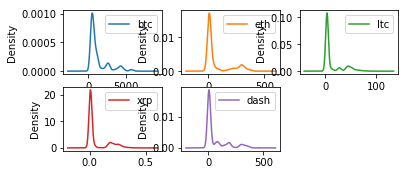

In [54]:
from pandas import read_csv
from pandas import set_option
from matplotlib import pyplot
filename = "all_dollar_prices.csv"
names = ['date', 'btc', 'eth', 'ltc', 'xrp', 'dash']
data = read_csv(filename, names=names, header=0, na_values='.')
set_option('display.width', 300)
set_option('precision', 10)
description = data.describe()
print(description)
correlations = data.corr(method='pearson')
print(correlations)
skew = data.skew()
print(skew)
data.hist()
data.plot(kind='density', subplots=True, layout=(3,3), sharex=False)
pyplot.show()